In [143]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import Dict, List, Tuple


def extract_countries_and_values(
    file_name: str, 
    countries: str, 
    countries_list: list[str], 
    death_type: str, 
    death_values_list: list[str],
    column_values: str, 
    period: str,  
    delimiter=',', 
    encoding='utf-8',
    chunk_size=10000 
) -> dict[str, list[tuple[str, float]]]: 
    result = {}

    try:
        for chunk in pd.read_csv(file_name, delimiter=delimiter, encoding=encoding, 
                                 usecols=[countries, death_type, column_values, period] if death_type else [countries, death_type, column_values, period],
                                 chunksize=chunk_size, on_bad_lines='skip'):
            period_data = [2020]
            chunk = chunk[chunk[countries].isin(countries_list)]
            chunk = chunk[chunk[period].isin(period_data)]
            chunk = chunk[chunk[death_type].isin(death_values_list)]
            
            chunk[column_values] = pd.to_numeric(chunk[column_values], errors='coerce')

            
            chunk = chunk.drop_duplicates(subset=[countries, death_type, column_values])
            
            chunk_result = (
                chunk.groupby([countries, death_type])  
                .agg({column_values: 'first'})  
                .reset_index()  
            )


            for _, row in chunk_result.iterrows():
                country = row[countries]
                death_values_list_value = row[death_type]
                value = row[column_values]
        
                if country not in result:
                    result[country] = [(death_values_list_value, value)] 
                else:  
                    if not any(edu[0] == death_values_list_value for edu in result[country]):
                        result[country].append((death_values_list_value, value)) 
       

        return result  

    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found.")
        return {}
    except pd.errors.ParserError as e:
        print(f"Parsing error: {e}")
        return {}
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return {}


def solve_data(
    death_rates: dict[str, list[tuple[str, float]]],
    pollution_list: dict[str, list[tuple[str, float]]]):

    countries = list(death_rates.keys())
    colors = ['r', 'g', 'b', 'm', 'c', 'y', 'orange']
    markers = ['o', 'D', 'v']
    death_rates_check = ['Respiratory system diseases mortality crude rate', 'Circulatory system diseases mortality crude rate']
    country_colors = {countries[i]: colors[i] for i in range(len(countries))}

    legend_handles_death = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgray', markersize=10, label='Respiratory system diseases mortality crude rate'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='darkgray', markersize=10, label='Circulatory system diseases mortality crude rate')
    ]
    

    plt.figure(figsize=(9, 6))
    plt.xlabel('Death rate amount 100 000 population', fontsize=10)
    plt.ylabel('Exposure pollution amount', fontsize=10)
    plt.title('Scatter Plot of exposure pollution vs death rates')

    country_handles = []

    for country in countries:
        for j in range(len(death_rates[country])):
            if death_rates_check[0] == death_rates[country][j][0]:
                death_value = float(death_rates[country][j][1])

                pollution_value = [pollution_list[country][0][1]]

                if pollution_value: 
                    plt.scatter(death_value, pollution_value, color=country_colors[country], marker='o', label=country)
                
            if death_rates_check[1] == death_rates[country][j][0]:
                death_value = float(death_rates[country][j][1])

                pollution_value = [pollution_list[country][0][1]]

                if pollution_value:
                    plt.scatter(death_value, pollution_value, color=country_colors[country], marker='D')    

    country_handles = [Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=country) for country, color in country_colors.items()]
    all_handles = country_handles + legend_handles_death
    
    plt.legend(handles=all_handles, title='Legend', loc='upper right', ncol=1, handleheight=1.4, labelspacing=0.7, fontsize=8)

    plt.tight_layout()
    plt.tight_layout()
    plt.savefig("scatter_plot_pollution.pdf", format="pdf")
    plt.show()

{'Colombia': [('More than 15 µg/m³', 23.860519)], 'Korea': [('More than 15 µg/m³', 99.080391)], 'Czechia': [('More than 15 µg/m³', 23.42753)], 'Hungary': [('More than 15 µg/m³', 29.993906)], 'Japan': [('More than 15 µg/m³', 8.3843756)], 'Austria': [('More than 15 µg/m³', 0.59629655)], 'Mexico': [('More than 15 µg/m³', 71.913162)]}


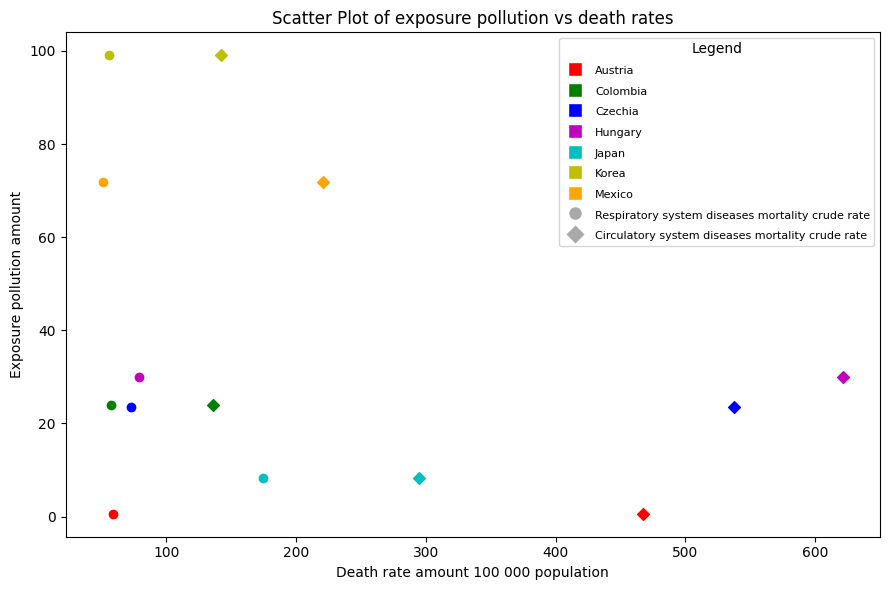

In [144]:
file_name_pollution = './data/air_pollution.csv'
file_name_death_rate = './data/death_by_air_pollution.csv'

countries_list = ['Austria', 'Czechia', 'Hungary', 'Japan', 'Korea', 'Mexico', 'Colombia']
values_list_e = ['More than 15 µg/m³']
death_rate_values_list_i = ['Respiratory system diseases mortality crude rate', 'Circulatory system diseases mortality crude rate']

result_death = extract_countries_and_values(file_name_death_rate, 'Country', countries_list, 'Measure', death_rate_values_list_i, 'OBS_VALUE', 'TIME_PERIOD', delimiter=',', encoding='utf-8')
result_pollution = extract_countries_and_values(file_name_pollution, 'Reference area', countries_list, 'Exposure levels (WHO Air Quality Guidelines)', values_list_e, 'OBS_VALUE', 'TIME_PERIOD', delimiter=',', encoding='utf-8')
solve_data(result_death, result_pollution)
